In [1]:
import json, os, sys, pickle, re

import gensim
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import sentencepiece as spm


from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from konlpy.tag import Mecab
from tqdm.notebook import tqdm

In [2]:
def clean_reivew(review):
    review = ''.join(re.compile('[가-힣.!? ]').findall(review))
    review = re.sub('\n', ' ', review)
    review = re.sub(r'\!+', '!', review)
    review = re.sub(r'\?+', '?', review)
    review = re.sub(r'\.+', '.', review)
    review = re.sub(r'\([^)]*\)', '', review)    # 괄호 안 내용 삭제
    review = re.sub(r'\[[^)]*\]', '', review)    # 대괄호 안 내용 삭제
    review = re.findall('.*?[.!\?]', review)
    return [line.strip() for line in review if len(line.strip()) > 1]

<>:9: DeprecationWarning: invalid escape sequence \?
<>:9: DeprecationWarning: invalid escape sequence \?
<>:9: DeprecationWarning: invalid escape sequence \?
<ipython-input-2-64c5ac48b340>:9: DeprecationWarning: invalid escape sequence \?
  review = re.findall('.*?[.!\?]', review)


In [3]:
with open('스킨케어.pkl', 'rb') as f:
    raw_dataset = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '스킨케어.pkl'

In [10]:
with open('화장품_미용.pkl', 'rb') as f:
    raw_dataset = pickle.load(f)

In [4]:
raw_dataset

,리뷰,rating
0,원래 스킨을 안 쓰다가 화장솜이랑 같이 사서 세수후에 얼굴을 닦는데 화장솜에 얼굴에...,5.0
1,항상 사용하는 제품! 2년 정도 쓴 것 같은데 안 좋은 점을 아직도 찾지 못했네요~...,5.0
2,제가 민감성피부인데요 쓰고나서 트러블이나 얼굴 빨게지는 증상 전혀없고 좋아요.,5.0
3,이거 좋더믄 말은 많이 들어서 처음 사봐ㅛ는데 엄청 순한게 느껴지고 닦토로 쓰는데 ...,5.0
4,후기가 좋아 구입했고 사용해봐야 알 것 같습니다.^^,5.0
...,...,...
3848696,재구매했어요. 오일 섞인 미스트를 선호 하는데 이것만한건 없는듯. 다 쓰면 또 구매...,4.0
3848697,광채미스트란 말에 낚였네요 광채는 어디서 나오는지 알수가 없네요..,1.0
3848698,오일이 너무 적은것같긴 하지만 가을철 사용하기에 딱이에요.,5.0
3848699,좋아요~~또 시킬려구요,5.0


# raw_dataset

In [188]:
raw_dataset = raw_dataset.sample(100000)

In [189]:
cleaning_reivew = []
for review, rating in raw_dataset.itertuples(index=False):
    temp_list = []
    
    temp_review = clean_reivew(review)
    
    if(len(temp_review) > 0):
        temp_review = ' '.join(temp_review)
        temp_list.append(temp_review)
        temp_list.append(rating)
        #print(temp_list)
        
        cleaning_reivew.append(temp_list)

In [190]:
cleaning_reivew = pd.DataFrame(cleaning_reivew, columns=['리뷰', 'rating'])

In [191]:
cleaning_reivew

,리뷰,rating
0,늘 쓰는거.,5.0
1,아직 쓴지 몇일 안됐지만 점점 좋아지리라 믿습니다! 화장품 잘못쓰면 좁쌀 올라오는 ...,4.0
2,끈적임이 없고 잘 흡수되네요.,5.0
3,워낙 유명한제품이라. 사용하던제품이라 믿고 구입했고요가지샘플을 넣어보내셨더라구요.,5.0
4,촉촉하고 순해서 좋아요!,5.0
...,...,...
37171,빠른 배송 좋아요.,5.0
37172,세번째구매예요.,5.0
37173,아직 안 써봤는데생각보다 작네요 배송 빨라서 좋습니다잘 쓸게요!,5.0
37174,제품도 넘 좋고 같이온 샘플 완전 좋아요 종류별로 다양하니.,5.0


# 띄어쓰기 토크나이징

In [62]:
tokenized_doc = cleaning_reivew['리뷰'].apply(lambda x: x.split())
print(len(tokenized_doc))
print(tokenized_doc)

364988
0                                              [건데, 구매, 배송]
1         [이니스, 프리, 브로우, 이니스, 프리, 브로우, 번, 멘탈, 걸, 가격, 손해,...
2                                                   [곳, 사요]
3                                               [갤, 후기, 흡수]
4         [파마, 날, 구매, 생각, 파마, 사용, 컬링, 유지, 만족, 중, 흡수, 제품,...
                                ...                        
364983                                  [만족, 해용, 배송, 하루, 만]
364984                                                   []
364985                                                 [배송]
364986                [립스틱, 개, 매장, 열, 천, 원, 정도, 거기, 무료, 배송]
364987                                                  [삿]
Name: 리뷰, Length: 364988, dtype: object


# globalspm 토크나이징

In [192]:
sp = spm.SentencePieceProcessor()
sp.Load('global_spm.model')

True

In [193]:
tokenized_doc = cleaning_reivew['리뷰'].apply(lambda x: sp.EncodeAsPieces(x))
print(len(tokenized_doc))
print(tokenized_doc)

37176
0                                            [▁늘, ▁쓰는거, .]
1        [▁아직, ▁쓴지, ▁몇일, ▁안, 됐지만, ▁점점, ▁좋아지, 리라, ▁믿습니다,...
2                            [▁끈적임이, ▁없고, ▁잘, ▁흡수되, 네요, .]
3        [▁워낙, ▁유명한, 제품이라, ., ▁사용하던, 제품이라, ▁믿고, ▁구입, 했고...
4                                   [▁촉촉하고, ▁순해서, ▁좋아요, !]
                               ...                        
37171                                  [▁빠른, ▁배송, ▁좋아요, .]
37172                                    [▁세번째, 구매, 예요, .]
37173    [▁아직, ▁안, ▁써봤는데, 생각보다, ▁작네요, ▁배송, ▁빨라서, ▁좋습니다,...
37174    [▁제품도, ▁넘, ▁좋고, ▁같이, 온, ▁샘플, ▁완전, ▁좋아요, ▁종류별로,...
37175    [▁주위에서, ▁프로폴리스, 앰플, ▁좋다고해서, ▁살까말까, ▁고민중, 이였는데,...
Name: 리뷰, Length: 37176, dtype: object


In [201]:
tokenized_doc = tokenized_doc.apply(lambda x:[sent.replace("▁","") for sent in x])

# konlpy 토크나이징

In [40]:
mecab = Mecab()

In [41]:
tokenized_doc = cleaning_reivew['리뷰'].apply(lambda x: mecab.nouns(x))
print(len(tokenized_doc))
print(tokenized_doc)

37914
0                                                  [때, 불안]
1        [토너, 트러블, 케어, 바라지, 세안, 후, 잔여물, 용, 조금, 느낌, 구성, ...
2        [앰, 플, 크림, 브라이트, 닝, 앰, 플, 구매, 여름철, 사용, 가격, 바, ...
3        [파파, 레서피, 흔적, 크림, 생각, 리치, 지복, 합성, 제게, 걱정, 효과, ...
4                                                     [사용]
                               ...                        
37909                                        [어머니, 건데, 구입]
37910                                          [물, 부담, 느낌]
37911                                          [알콜, 얼굴, 저]
37912                                           [기대, 것, 것]
37913                                              [설화, 수]
Name: 리뷰, Length: 37914, dtype: object


# stop words

In [205]:
with open('stopwords.txt', 'rt', encoding='utf-8')as f:
    stopwords = f.read().splitlines() 

In [206]:
tokenized_doc = tokenized_doc.apply(lambda x: [word for word in x if word not in (stopwords)])#불용어 제거
print(len(tokenized_doc))
print(tokenized_doc)

37176
0                                              [늘, 쓰는거, .]
1        [아직, 쓴지, 몇일, 안, 됐지만, 점점, 좋아지, 리라, 믿습니다, !, 화장품...
2                                [끈적임이, 없고, 잘, 흡수되, 네요, .]
3        [워낙, 유명한, 제품이라, ., 사용하던, 제품이라, 믿고, 구입, 했고요, 가지...
4                                      [촉촉하고, 순해서, 좋아요, !]
                               ...                        
37171                                     [빠른, 배송, 좋아요, .]
37172                                     [세번째, 구매, 예요, .]
37173    [아직, 안, 써봤는데, 생각보다, 작네요, 배송, 빨라서, 좋습니다, 잘, 쓸게요...
37174        [제품도, 넘, 좋고, 온, 샘플, 완전, 좋아요, 종류별로, 다양, 하니, .]
37175    [주위에서, 프로폴리스, 앰플, 좋다고해서, 살까말까, 고민중, 이였는데, !, 이...
Name: 리뷰, Length: 37176, dtype: object


# not tfidf

In [207]:
dictionary = corpora.Dictionary(tokenized_doc)
corpus = [dictionary.doc2bow(text) for text in tokenized_doc]
print(corpus[1])

[(3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]


In [208]:
len(dictionary)

14210

In [209]:
NUM_TOPICS = 7 #20개의 토픽, k=20
#ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel = gensim.models.ldamulticore.LdaModel(corpus=corpus, 
                                               num_topics = NUM_TOPICS, 
                                               id2word=dictionary, 
                                               passes=10)#멀티코어

In [210]:
cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Coherence",coherence)
print('\nPerplexity: ', ldamodel.log_perplexity(corpus))

Coherence -3.1236132140137722

Perplexity:  -7.604570559072716


In [211]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic,"\n")

(0, '0.249*"!" + 0.064*"좋아요" + 0.029*"너무" + 0.026*"" + 0.012*"완전" + 0.012*"진짜" + 0.011*"정말" + 0.008*"촉촉하고" + 0.008*"배송도" + 0.008*"좋네요"') 

(1, '0.177*"." + 0.026*"잘" + 0.024*"좋아요" + 0.014*"같아요" + 0.014*"쓰고" + 0.011*"좋습니다" + 0.009*"있습니다" + 0.009*"있어요" + 0.008*"도" + 0.008*"촉촉하고"') 

(2, '0.083*"." + 0.020*"" + 0.020*"아직" + 0.013*"?" + 0.011*"사용" + 0.010*"써" + 0.008*"더" + 0.008*"해서" + 0.008*"써보고" + 0.006*"꾸준히"') 

(3, '0.046*"." + 0.015*"크림" + 0.011*"라" + 0.010*"마음에" + 0.009*"들어요" + 0.009*"맘에" + 0.009*"는" + 0.006*"에센스" + 0.006*"더" + 0.006*"굿"') 

(4, '0.072*"." + 0.025*"잘" + 0.022*"도" + 0.016*"은" + 0.010*"네요" + 0.008*"?" + 0.008*"받았습니다" + 0.007*"향이" + 0.007*"" + 0.006*"생각보다"') 

(5, '0.035*"." + 0.016*"도" + 0.012*"는" + 0.012*"피부" + 0.012*"피부가" + 0.009*"바르고" + 0.008*"은" + 0.008*"고" + 0.007*"많이" + 0.006*"한"') 

(6, '0.166*"." + 0.019*"잘" + 0.018*"배송" + 0.016*"배송도" + 0.016*"늘" + 0.015*"만족합니다" + 0.015*"항상" + 0.015*"감사합니다" + 0.015*"저렴하게" + 0.013*"쓰던"') 



In [28]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [31]:
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [33]:
topictable = make_topictable_per_doc(ldamodel, corpus)
topictable = topictable.reset_index() # 문서 번호을 의미하는 열(column)로 사용하기 위해서 인덱스 열을 하나 더 만든다.
topictable.columns = ['문서 번호', '가장 비중이 높은 토픽', '가장 높은 토픽의 비중', '각 토픽의 비중']

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,2.0,0.9614,"[(2, 0.9613975)]"
1,1,0.0,0.7997,"[(0, 0.7997293), (1, 0.050066765), (2, 0.05007..."
2,2,4.0,0.8660,"[(0, 0.033465855), (1, 0.033493634), (2, 0.033..."
3,3,4.0,0.5058,"[(0, 0.014423401), (1, 0.014455306), (2, 0.450..."
4,4,3.0,0.5990,"[(0, 0.10023877), (1, 0.10024335), (2, 0.10024..."
...,...,...,...,...
3507,3507,1.0,0.7738,"[(0, 0.018429065), (1, 0.77384084), (2, 0.0182..."
3508,3508,2.0,0.7990,"[(0, 0.05004452), (1, 0.05004527), (2, 0.79896..."
3509,3509,3.0,0.9521,"[(0, 0.011936927), (1, 0.012088183), (2, 0.011..."
3510,3510,2.0,0.5996,"[(0, 0.10009808), (1, 0.10009996), (2, 0.59960..."


In [39]:
topictable.head(10)

,문서 번호,가장 비중이 높은 토픽,가장 높은 토픽의 비중,각 토픽의 비중
0,0,2.0,0.9614,"[(2, 0.9613975)]"
1,1,0.0,0.7997,"[(0, 0.7997293), (1, 0.050066765), (2, 0.05007..."
2,2,4.0,0.8660,"[(0, 0.033465855), (1, 0.033493634), (2, 0.033..."
3,3,4.0,0.5058,"[(0, 0.014423401), (1, 0.014455306), (2, 0.450..."
4,4,3.0,0.5990,"[(0, 0.10023877), (1, 0.10024335), (2, 0.10024..."
5,5,4.0,0.5873,"[(0, 0.034301516), (1, 0.033752747), (2, 0.310..."
6,6,2.0,0.7326,"[(0, 0.066731416), (1, 0.06678536), (2, 0.7326..."
7,7,0.0,0.4313,"[(0, 0.43134135), (1, 0.06769612), (2, 0.06819..."
8,8,3.0,0.5016,"[(0, 0.42233846), (1, 0.025382455), (2, 0.0252..."
9,9,1.0,0.7991,"[(0, 0.05046327), (1, 0.7990879), (2, 0.050041..."


# tfidf 이용

In [208]:
detokenized_doc = []
for i in range(len(cleaning_reivew)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

In [209]:
detokenized_doc

['▁계속 ▁키엘 만 ▁쓰고 ▁있어서 ▁만족해요 .',
 '▁계속 ▁쓰게 되는 ▁세럼 입니다 . ▁발랐을때 ▁산뜻한 ▁느낌이 ▁너무 ▁좋아요 !',
 '▁너무너무 ▁좋아요 . ▁벌써 ▁몇통째 인지 몰라 요 .',
 '▁이거 ▁진짜 ▁최고네요 . ▁촉촉하니 ▁너무 ▁좋아요 .',
 '▁아들이 ▁피부가 ▁너무 ▁심해서 ▁샀어요 ▁어 성 초 ▁비누 ▁씻고 ▁이걸로 ▁마무리 ▁시켰습니다 .',
 '▁가 ▁생각보다 작 아요 .',
 '▁겟잇뷰티 ▁나온 ▁보았는데 ▁별로 ▁신뢰가 ▁가지 ▁않아서 ▁연예인들 ▁나와서 ▁하는거 ▁보 믄 ▁대부분 ▁홍보 인 게 ▁많아서 얼굴 ▁잡티 랑 ▁기미가 ▁조금 ▁있어서 ▁한번 ▁구매해 ▁봤어요 . ▁미백 제품 들은 ▁꾸준히 ▁사용해야 ▁하는거 고 예방 이지 ▁없애 지는 ▁못할 거 ▁같은데 ▁지금 ▁사용중입니다 . ▁아침 ▁저녁 ▁사용하고 요 . ▁오늘 ▁ 일째 입니다 . ▁밝기 는 ▁모르겠고 ▁피부가 ▁땡기는 ▁건성피부 인데 ▁덜 해졌어요 . ▁그건 ▁확실 . ▁그리고 ▁피부결 도 ▁매끈 해졌어요 . ▁딜 상품 ▁가격저렴 해서 ▁안 티 링 클 ▁제품도 ▁구매해요 !',
 '▁제품 ▁넉넉히 ▁주니 ▁정말 ▁맘 편 히 ▁여유있게 ▁써서 ▁좋아요 ▁이번이 ▁몇번째 ▁구매 인지 ▁기억 도 ▁안나 .',
 '▁톤업크림 ▁대용으로 ▁사용중인데 ▁처음에 ▁바르면 ▁백탁현상 ▁살짝 ▁있어서 ▁얼굴이 ▁떠 보 수 ▁있으니 ▁약간 만 ▁발라야 하고 ▁충분히 ▁두 겨 줘야 할것 ▁같아요 ▁그러면 ▁전체적으로 ▁화사해 지는 ▁느낌이에요 ▁아직 ▁오래 ▁사용해보 지 ▁않아서 ▁효과는 ▁잘 ▁모르겠으나 ▁엄청난 ▁미백 ▁기대 하기는 ▁힘들 겠죠 ?',
 '▁요즘 ▁계절 ▁민감 해진 ▁피부를 ▁위해 ▁구입했어요 !',
 '▁오일 같은데 ▁바르면 ▁엄청 ▁무겁게 ▁올라가 요 ! ▁약간 ▁피부를 ▁실크 ▁만들어주 고 ▁이거 쓸 땐 ▁ 드름 ▁거의 ▁안나요 ! ▁촉촉함 ▁넘어서 ▁끈적거리 는데 ▁저는 ▁완전 ▁파워 ▁건성이라 ▁너무너무 ▁좋지만 ▁중성 이나 ▁지성 분

In [210]:
cleaning_reivew['리뷰'] = detokenized_doc

In [211]:
cleaning_reivew

,리뷰,rating
0,▁계속 ▁키엘 만 ▁쓰고 ▁있어서 ▁만족해요 .,5.0
1,▁계속 ▁쓰게 되는 ▁세럼 입니다 . ▁발랐을때 ▁산뜻한 ▁느낌이 ▁너무 ▁좋아요 !,5.0
2,▁너무너무 ▁좋아요 . ▁벌써 ▁몇통째 인지 몰라 요 .,5.0
3,▁이거 ▁진짜 ▁최고네요 . ▁촉촉하니 ▁너무 ▁좋아요 .,5.0
4,▁아들이 ▁피부가 ▁너무 ▁심해서 ▁샀어요 ▁어 성 초 ▁비누 ▁씻고 ▁이걸로 ▁마...,5.0
...,...,...
373605,▁정말 ▁바르는 ▁순간 ▁촉촉하고 ▁잘 ▁흡수되 서 ▁다음날 ▁피부 표현 ▁최고입니다 .,5.0
373606,▁이틀째 ▁사용중인데 ▁향은 ▁강하지 ▁않고 ▁두번 씩 ▁바르면 ▁대박 ▁촉촉 ▁역...,5.0
373607,▁엄마 ▁쓰 신다고 ▁해서 ▁주문했는데 ▁배송도 ▁빠르고 ▁용량도 ▁많아서 ▁좋아요 !,5.0
373608,▁바디로션 ▁섞어 바르 니까 ▁정말 ▁촉촉하고 ▁건조함이 ▁없어요 ! ▁유통기한 ▁...,4.0


In [377]:
from sklearn.feature_extraction.text import TfidfVectorizer
#vectorizer = TfidfVectorizer(max_features= 1000) # 상위 1,000개의 단어를 보존 
vectorizer = TfidfVectorizer(max_df=0.9, ngram_range=(1,2), min_df=10)
X = vectorizer.fit_transform(cleaning_reivew['리뷰'])

X.shape # TF-IDF 행렬의 크기 확인

(373610, 64797)

In [378]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,
                                    learning_method='online',
                                    random_state=777,
                                    max_iter=1, 
                                    n_jobs=8)

In [ ]:
lda_top=lda_model.fit_transform(X)

In [ ]:
print(lda_model.components_)
print(lda_model.components_.shape)

In [ ]:
terms = vectorizer.get_feature_names()#단어 집합

def get_topics(components, feature_names, n=15):
    for idx, topic in enumerate(components):
        print("\nTopic %d:\n" % (idx+1), 
              [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lda_model.components_,terms)

# fasttext

In [13]:
from gensim.models import FastText

In [14]:
non_start_symbol_doc = tokenized_doc.apply(lambda x:[sent.replace("▁","") for sent in x])

In [156]:
ft_vectorizer = FastText(non_start_symbol_doc[:10000], sg=1, size=100, word_ngrams=3, workers=8, window=2)

In [157]:
ft_vectorizer.wv.most_similar('발림')

[('발림성이', 0.9954236149787903),
 ('발림성은', 0.9897715449333191),
 ('발림성', 0.9873442053794861),
 ('발림도', 0.9869816303253174),
 ('흡수력', 0.9843650460243225),
 ('흡수력이', 0.9838896989822388),
 ('분사력', 0.9835293889045715),
 ('발림성도', 0.9779806137084961),
 ('성도', 0.9739184379577637),
 ('보습력', 0.97232985496521)]

vectorizer2 = FastText(tokenized_doc, sg=1, size=128, word_ngrams=3, workers=8, window=2)

vectorizer2.wv.most_similar('발림')

In [117]:
len(non_start_symbol_doc)

373623

In [168]:
X = []
for vocab in non_start_symbol_doc[:100000]:
    temp_list = []
    temp = ft_vectorizer.wv.most_similar(vocab, topn=100)
    [temp_list.append(x[1]) for x in temp]
    X.append(temp_list)

In [169]:
X = np.array(X)
X.shape

(100000, 100)

In [172]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=10,
                                    learning_method='online',
                                    random_state=777,
                                    max_iter=1,
                                    n_jobs=8)

In [173]:
lda_top=lda_model.fit_transform(X)

In [174]:
print(lda_model.components_)
print(lda_model.components_.shape)

[[8.63429289e+03 8.65961322e+03 8.55633867e+03 8.48279307e+03
  8.40872953e+03 8.47338591e+03 8.56445516e+03 8.57442473e+03
  8.37836722e+03 8.53884940e+03 8.54869259e+03 8.48794822e+03
  8.58601248e+03 8.26063442e+03 8.50946993e+03 8.34739168e+03
  8.48183821e+03 8.34107013e+03 8.55787947e+03 8.45797546e+03
  8.45137233e+03 8.48303094e+03 8.45326889e+03 8.36860428e+03
  8.40832163e+03 8.56736401e+03 8.40872290e+03 8.36906747e+03
  8.36528377e+03 8.53755308e+03 8.43223899e+03 8.38691273e+03
  8.47480456e+03 8.43415948e+03 8.49580723e+03 8.44369484e+03
  8.32968427e+03 8.44685839e+03 8.28338338e+03 8.53786568e+03
  8.43370373e+03 8.47349871e+03 8.31187735e+03 8.43224367e+03
  8.44498313e+03 8.37669857e+03 8.39629624e+03 8.52944674e+03
  8.48213170e+03 8.39809014e+03 8.39652101e+03 8.35088118e+03
  8.32600572e+03 8.29165186e+03 8.33054447e+03 8.46686422e+03
  8.49417125e+03 8.41185137e+03 8.39912117e+03 8.18471792e+03
  8.36027957e+03 8.48650178e+03 8.31780194e+03 8.43753938e+03
  8.3950

In [175]:
ft_vectorizer.wv.similar_by_vector(lda_model.components_[1])

[('바르고', 0.23786668479442596),
 ('쓰고', 0.19828583300113678),
 ('사용하고', 0.17959143221378326),
 ('하고', 0.16817252337932587),
 ('사용', 0.15388372540473938),
 ('바르', 0.1533776819705963),
 ('발라', 0.14025524258613586),
 ('잘사용하고', 0.13507278263568878),
 ('바르면', 0.11979524791240692),
 ('르고', 0.1162649616599083)]

In [176]:
lda_model.components_[9][0]

10793.055652789215

In [177]:
#terms = ft_vectorizer.get_feature_names()#단어 집합

def get_topics(components, n=15):
    for idx, topic in enumerate(components):
        print("\nTopic %d:\n" % (idx+1), 
              [x[0] for x in ft_vectorizer.wv.similar_by_vector(components[idx], topn=n)],"\n",
              [topic[i].round(2) for i in topic.argsort()[:-n - 1:-1]])
        
get_topics(lda_model.components_)


Topic 1:
 ['바르고', '쓰고', '사용하고', '하고', '바르', '사용', '발라', '잘사용하고', '바르면', '르고', '사용하면', '이용하고', '잘쓰고', '사용하고있어요', '애용하고'] 
 [8659.61, 8634.29, 8586.01, 8574.42, 8567.36, 8564.46, 8557.88, 8556.34, 8548.69, 8538.85, 8537.87, 8537.55, 8529.45, 8509.47, 8495.81]

Topic 2:
 ['바르고', '쓰고', '사용하고', '하고', '사용', '바르', '발라', '잘사용하고', '바르면', '르고', '사용하면', '이용하고', '잘쓰고', '사용하고있어요', '애용하고'] 
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Topic 3:
 ['바르고', '쓰고', '사용하고', '하고', '사용', '바르', '발라', '잘사용하고', '바르면', '르고', '사용하면', '이용하고', '잘쓰고', '사용하고있어요', '애용하고'] 
 [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

Topic 4:
 ['바르고', '쓰고', '사용하고', '하고', '사용', '바르', '발라', '잘사용하고', '바르면', '르고', '사용하면', '이용하고', '잘쓰고', '애용하고', '사용하고있어요'] 
 [21155.7, 21144.54, 21122.72, 21116.2, 21095.74, 21074.89, 21064.67, 21062.92, 21045.13, 21029.59, 20931.39, 20931.06, 20923.16, 20922.25, 20913.8]

Topic 5:
 ['바르고', '쓰고', '사용하고', '하고', '사용', '바르', '발라', '잘사용하고', '바르면',

num_topic 1
Coherence    -3.298929816778899
Perplexity:  -9.440168390537245

num_topic 2
Coherence    -3.429807050655773
Perplexity:  -9.513152770204728

num_topic 3
Coherence    -6.265979339997977
Perplexity:  -9.605547163378194

num_topic 4
Coherence    -5.743691487141795
Perplexity:  -9.752081316507848

num_topic 5
Coherence    -5.435060956003456
Perplexity:  -9.876665247567562

num_topic 6
Coherence    -6.323158767719988
Perplexity:  -10.067615034315091

num_topic 7
Coherence    -6.282751367988385
Perplexity:  -10.400347146581485

num_topic 8
Coherence    -8.21011740873839
Perplexity:  -10.78586636733533

num_topic 9
Coherence    -8.015164802299669
Perplexity:  -11.291646217523946

num_topic 10
Coherence    -8.489365104150231
Perplexity:  -11.915058484641602

num_topic 11
Coherence    -8.493241619382815
Perplexity:  -12.628865774100134

num_topic 12
Coherence    -9.330492587531221
Perplexity:  -13.506361628028564

num_topic 13
Coherence    -9.639021422851293
Perplexity:  -14.193431915971694

num_topic 14
Coherence    -8.417506532441815
Perplexity:  -14.765606306165306

num_topic 15
Coherence    -7.666586179411904
Perplexity:  -15.254775965484491

num_topic 16
Coherence    -8.565601809177176
Perplexity:  -15.709515176325255

num_topic 17
Coherence    -9.58189069402978
Perplexity:  -16.127335239277723

num_topic 18
Coherence    -9.24608604424278
Perplexity:  -16.541137033145237

num_topic 19
Coherence    -8.908126121011495
Perplexity:  -16.95732629117389

num_topic 20
Coherence    -8.901985851885243
Perplexity:  -17.36897843369132

num_topic 21
Coherence    -8.998730039382213
Perplexity:  -17.795226061783886

num_topic 22
Coherence    -9.589209221224987
Perplexity:  -18.22390030466499

num_topic 23
Coherence    -10.525591735073307
Perplexity:  -18.66926048790735

num_topic 24
Coherence    -10.130311245725167
Perplexity:  -19.061887042263123

num_topic 25
Coherence    -10.688450182255352
Perplexity:  -19.48405585327985

num_topic 26
Coherence    -9.677960049898921
Perplexity:  -19.944222856672535

num_topic 27
Coherence    -10.375132301487413
Perplexity:  -20.348753749671683

num_topic 28
Coherence    -10.27151517366274
Perplexity:  -20.749554832358456

-3.298929816778899
,-9.440168390537245
,-3.429807050655773
,-9.513152770204728
,-6.265979339997977
,-9.605547163378194
,-5.743691487141795
,-9.752081316507848
,-5.435060956003456
,-9.876665247567562
,-6.323158767719988
,-10.067615034315091
,-6.282751367988385
,-10.400347146581485
,-8.21011740873839
,-10.78586636733533
,-8.015164802299669
,-11.291646217523946
,-8.489365104150231
,-11.915058484641602
,-8.493241619382815
,-12.628865774100134
,-9.330492587531221
,-13.506361628028564
,-9.639021422851293
,-14.193431915971694
,-8.417506532441815
,-14.765606306165306
,-7.666586179411904
,-15.254775965484491
,-8.565601809177176
,-15.709515176325255
,-9.58189069402978
,-16.127335239277723
,-9.24608604424278
,-16.541137033145237
,-8.908126121011495
,-16.95732629117389
,-8.901985851885243
,-17.36897843369132
,-8.998730039382213
,-17.795226061783886
,-9.589209221224987
,-18.22390030466499
,-10.525591735073307
,-18.66926048790735
,-10.130311245725167
,-19.061887042263123
,-10.688450182255352
,-19.48405585327985
,-9.677960049898921
,-19.944222856672535
,-10.375132301487413
,-20.348753749671683
,-10.27151517366274
,-20.749554832358456

num_topic 1
Coherence -2.37741106134425
Perplexity:  -7.897812440158737

num_topic 2
Coherence -2.722551730260058
Perplexity:  -7.874487759150053

num_topic 3
Coherence -2.7079553085494794
Perplexity:  -7.891936236233233

num_topic 4
Coherence -2.708429338092511
Perplexity:  -7.937719000613379

num_topic 5
Coherence -2.984223823023899
Perplexity:  -7.984745261802842

num_topic 6
Coherence -3.04154486044616
Perplexity:  -8.048068336149043

num_topic 7
Coherence -3.848859680352439
Perplexity:  -8.075053872732827

num_topic 8
Coherence -3.273614480509786
Perplexity:  -8.13875550887722

num_topic 9
Coherence -3.8098289071703033
Perplexity:  -8.234113256509206

num_topic 10
Coherence -4.186436881325565
Perplexity:  -8.409619683717242

num_topic 11
Coherence -4.256564887207969
Perplexity:  -8.745056215385132

num_topic 12
Coherence -3.808897644234967
Perplexity:  -9.112956678972468

num_topic 13
Coherence -5.591273839512299
Perplexity:  -9.32712920549897

num_topic 14
Coherence -4.275857830304356
Perplexity:  -9.455291521421477

num_topic 15
Coherence -4.187394420056601
Perplexity:  -9.56080027195387


-2.37741106134425
,  -7.897812440158737

,-2.722551730260058
,  -7.874487759150053

,-2.7079553085494794
,  -7.891936236233233

,-2.708429338092511
,  -7.937719000613379

,-2.984223823023899
,  -7.984745261802842

,-3.04154486044616
,  -8.048068336149043

,-3.848859680352439
,  -8.075053872732827

,-3.273614480509786
,  -8.13875550887722

,-3.8098289071703033
,  -8.234113256509206

,-4.186436881325565
,  -8.409619683717242

,-4.256564887207969
,  -8.745056215385132

,-3.808897644234967
,  -9.112956678972468

,-5.591273839512299
,  -9.32712920549897

,-4.275857830304356
,  -9.455291521421477

,-4.187394420056601
,  -9.56080027195387

aaa_list = [-2.37741106134425
,  -7.897812440158737

,-2.722551730260058
,  -7.874487759150053

,-2.7079553085494794
,  -7.891936236233233

,-2.708429338092511
,  -7.937719000613379

,-2.984223823023899
,  -7.984745261802842

,-3.04154486044616
,  -8.048068336149043

,-3.848859680352439
,  -8.075053872732827

,-3.273614480509786
,  -8.13875550887722

,-3.8098289071703033
,  -8.234113256509206

,-4.186436881325565
,  -8.409619683717242

,-4.256564887207969
,  -8.745056215385132

,-3.808897644234967
,  -9.112956678972468

,-5.591273839512299
,  -9.32712920549897

,-4.275857830304356
,  -9.455291521421477

,-4.187394420056601
,  -9.56080027195387]

In [101]:
def get_coherence_and_perplexity(num_topic):
    ldamodel = gensim.models.ldamulticore.LdaModel(corpus, 
                                                   num_topics = num_topic, 
                                                   id2word=dictionary, 
                                                   passes=10)#멀티코어
    
    cm = CoherenceModel(model=ldamodel, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("\nnum_topic", num_topic)
    print("Coherence :",coherence)
    perplexity = ldamodel.log_perplexity(corpus)
    print('Perplexity: ', perplexity)
    
    return coherence, perplexity


In [102]:
coh = []
per = []
for i in range(1,16):
    _coh, _per = get_coherence_and_perplexity(i)
    coh.append(_coh)
    per.append(_per)
                                              


num_topic 1
Coherence : -2.496331908191657
Perplexity:  -6.207686723513949

num_topic 2
Coherence : -2.7381824331064575
Perplexity:  -6.180083908143486

num_topic 3
Coherence : -2.9241027865378606
Perplexity:  -6.18752535232102

num_topic 4
Coherence : -3.117522161170785
Perplexity:  -6.2272511378413

num_topic 5
Coherence : -3.294053207333892
Perplexity:  -6.27141631488304

num_topic 6
Coherence : -3.4285215245491156
Perplexity:  -6.32951050490039

num_topic 7
Coherence : -3.3610486281527003
Perplexity:  -6.339101669865753

num_topic 8
Coherence : -3.774154012371199
Perplexity:  -6.385395953700362

num_topic 9
Coherence : -3.5235133071970446
Perplexity:  -6.411180803442329

num_topic 10
Coherence : -3.5278820017738397
Perplexity:  -6.464348494374686

num_topic 11
Coherence : -4.428767040907872
Perplexity:  -6.5719027886389885

num_topic 12
Coherence : -4.230186223884595
Perplexity:  -6.733812183423229

num_topic 13
Coherence : -4.422873188660469
Perplexity:  -6.961136541251055

num_t

coh = [-2.496331908191657,-2.7381824331064575 ,-2.9241027865378606 ,-3.117522161170785 , -3.294053207333892, -3.4285215245491156 ,-3.3610486281527003 ,-3.774154012371199 ,-3.5235133071970446 ,-3.5278820017738397 ,-4.428767040907872 ,-4.230186223884595 ,-4.422873188660469 ,-4.196980874773927 ,-4.482490551779505

]
per = [-6.207686723513949
,-6.180083908143486
,-6.18752535232102
,-6.2272511378413
,-6.27141631488304
,-6.32951050490039
,-6.339101669865753
,-6.385395953700362
,-6.411180803442329
,-6.464348494374686
,-6.5719027886389885
,-6.733812183423229
,-6.961136541251055
,-7.1525635973387764
,-7.23550636087294]



# coh, per

In [124]:
for i in range(16,31):
    _coh, _per = get_coherence_and_perplexity(i)
    coh.append(_coh)
    per.append(_per)


num_topic 16
Coherence : -5.00690566738742
Perplexity:  -7.310140527229716

num_topic 17
Coherence : -5.435897249256803
Perplexity:  -7.378019169412702

num_topic 18
Coherence : -4.976691876138737
Perplexity:  -7.464221619743987

num_topic 19
Coherence : -5.5310244835852105
Perplexity:  -7.5352902991995165

num_topic 20
Coherence : -5.613365681516901
Perplexity:  -7.6092104795110425

num_topic 21
Coherence : -6.180757537246715
Perplexity:  -7.66529265785026

num_topic 22
Coherence : -6.251572623109766
Perplexity:  -7.7161468681931025

num_topic 23
Coherence : -6.393396591321938
Perplexity:  -7.8068279716864355

num_topic 24
Coherence : -6.10640872856315
Perplexity:  -7.866270833422517

num_topic 25
Coherence : -7.064735613524821
Perplexity:  -7.948523723606219

num_topic 26
Coherence : -6.984034720896765
Perplexity:  -8.01596592190259

num_topic 27
Coherence : -7.364716408153749
Perplexity:  -8.074405595724443

num_topic 28
Coherence : -7.393719782902935
Perplexity:  -8.14534504442920

In [122]:
len(coh)

15

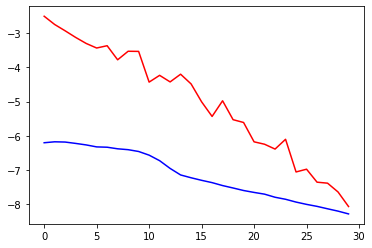

In [128]:
plt.plot(coh, c='r')
plt.plot(per, c='b')
plt.show()